In [2]:
import sjldpm
from sjldpm.apps.cond.try_cond_1 import *
import importlib
importlib.reload(sjldpm.apps.cond.try_cond_1)

import matplotlib.pyplot as plt

import matplotlib.image as mpimg
from skimage.transform import rescale, resize

from sjldpm.apps.reference.ddpm2_h import imread,list_pictures

2024-10-18 19:02:48.783074: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudart.so.12
Using TensorFlow backend.


In [3]:
def show_image(path,scale=1):
    img = mpimg.imread(path)
    if scale<1:
        img = rescale(img,scale)
    imgplot = plt.imshow(img)
    plt.show()

def show_image2(path1,path2):
    img1 = mpimg.imread(path1)
    img2 = mpimg.imread(path2)
    fig,axes= plt.subplots(1,2)
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    plt.show()

def to_displayable_img(img):
    return cv2.cvtColor( (img/2+0.5).astype(np.float32), cv2.COLOR_BGR2RGB)


In [4]:
gpuid = 0
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpuid}"
log_dir = use_log_dir(sjldpm,cfn,"loadPretrained",10)
# ------------------

config  = get_config()
print(" Create model ...")
model = call_by_inspect( get_model, config)
print(" ... Load weights ...")
path_ckpt = Path("/home/yumeng/workspace/DDPM-SuJL/Results-old/ddpm2__v2/version_1/weights/model.weights").as_posix()
model.load_weights(path_ckpt)

 Create model ...



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 128)       128000      input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 128 3456        input_1[0][0]                    
____________________________________________________________________________________________

2024-10-18 19:02:53.461908: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcuda.so.1
2024-10-18 19:02:53.502471: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1674] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.695
pciBusID: 0000:3b:00.0
2024-10-18 19:02:53.502521: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudart.so.12
2024-10-18 19:02:53.535727: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcublas.so.12
2024-10-18 19:02:53.537505: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcufft.so.11
2024-10-18 19:02:53.537829: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcurand.so.10
2024-10-18 19:02:53.540675: I tensorflow/stream_executor/platform/d

In [5]:
from dataclasses import dataclass
@dataclass
class State:
    stride = 25
    eta = 1
    stop_last_n = 10
    img_size = 128
    bar_alpha:np.ndarray = config["bar_alpha"]
    path = Path(log_dir,"upx_1.png").as_posix()
    # --- Computed constants ---
    T_ = None
    # --- State variables---
    z_samples = None  #  B, H, W, C
    upz_samples = None# 4B, H, W, C
    fsz_samples = None#  B,2H,2W, C
    alpha_=None
    sigma_ = None
    epsilon_ = None
state = State()

In [6]:
def compute_schedule(state):
    
    bar_alpha_ = state.bar_alpha[::state.stride]
    bar_alpha_pre_ = np.pad(bar_alpha_[:-1], [1, 0], constant_values=1)
    bar_beta_ = np.sqrt(1 - bar_alpha_**2)
    bar_beta_pre_ = np.sqrt(1 - bar_alpha_pre_**2)
    alpha_ = bar_alpha_ / bar_alpha_pre_
    sigma_ = bar_beta_pre_ / bar_beta_ * np.sqrt(1 - alpha_**2) * state.eta
    epsilon_ = bar_beta_ - alpha_ * np.sqrt(bar_beta_pre_**2 - sigma_**2)
    
    state.alpha_ = alpha_
    state.sigma_ = sigma_
    state.epsilon_ = epsilon_
    state.T_ = len(bar_alpha_)
    return state

In [7]:
def generate_sampling_start(state):
    state.z_samples = np.random.randn(1, state.img_size, state.img_size, 3)
    return state

In [8]:
def sampling_step(model,state, t:int,filed_name:str):
    stride = state.stride
    z = getattr(state,filed_name)
    bt = np.array([[t * stride]] * z.shape[0])
    z-= state.epsilon_[t] * model.predict([z, bt])
    z /= state.alpha_[t]
    z += np.random.randn(*z.shape) * state.sigma_[t]
    
    state.z= z
    return state

In [9]:
def z_samples_as_imgs(z_samples):
    x_samples = np.clip(z_samples,-1,1)
    imgs = (x_samples+1)/2* 255
    imgs = np.round(imgs, 0).astype('uint8')
    imgs = np.stack((imgs[...,2],imgs[...,1],imgs[...,0]),axis=3)
    return imgs

In [10]:
def demo_A(model):
    state = State()
    state = compute_schedule(state)
    state = generate_sampling_start(state)
    T_ = state.T_
    for t in tqdm(range(T_),ncols=0):
        t = T_ - t  - 1
        state = sampling_step(model,state,t,"z_samples")
    return state
    

  0% 0/40 [00:00<?, ?it/s]

2024-10-18 19:02:58.180648: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcublas.so.12
2024-10-18 19:02:59.619149: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudnn.so.8
100% 40/40 [00:07<00:00,  5.61it/s]


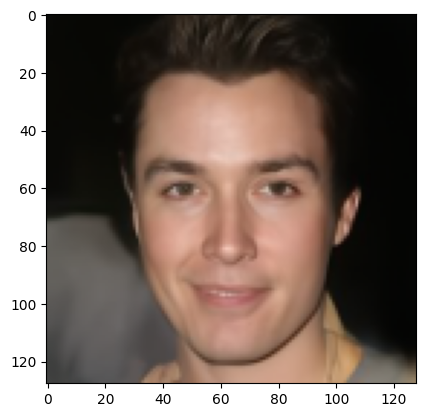

In [11]:
state = demo_A(model)
imgs = z_samples_as_imgs(state.z_samples)
plt.imshow(imgs[0])
plt.show()

In [12]:
def demo_B(model,stride,eta,n_last):
    state = State()
    state.stride = stride
    state.eta = eta
    state = compute_schedule(state)
    state = generate_sampling_start(state)
    T_ = state.T_
    assert n_last<T_
    for t in tqdm(range(T_-n_last),ncols=0):
        t = T_ - t  - 1
        state = sampling_step(model,state,t,"z_samples")
    
    print(f" - At t/T={t}/{T_},state.z_samples: shape={state.z_samples.shape}")
    state.upz_samples = np.zeros((4, *(state.z_samples.shape[1:])))
    for i in range(4):
        state.upz_samples[i,...] = state.z_samples[0,...] # copy
    for t in tqdm(range(T_ - n_last,T_),ncols=0):
        t = T_ - t  - 1
        state = sampling_step(model,state,t,"upz_samples")
        
    print(f" - At t/T={t}/{T_},state.z_samples: shape={state.z_samples.shape}")
    print(f" - At t/T={t}/{T_},state.upz_samples: shape={state.upz_samples.shape}")
    return state

  0% 0/5 [00:00<?, ?it/s]

100% 5/5 [00:00<00:00, 30.07it/s]


 - At t/T=45/50,state.z_samples: shape=(1, 128, 128, 3)


100% 45/45 [00:03<00:00, 12.34it/s]


 - At t/T=0/50,state.z_samples: shape=(1, 128, 128, 3)
 - At t/T=0/50,state.upz_samples: shape=(4, 128, 128, 3)
 - up_imgs: shape=(1, 256, 256, 3)


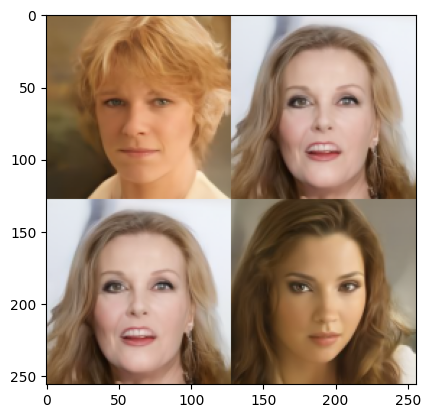

In [13]:
state = demo_B(model,stride = 20,eta = 1,n_last=45)
upz_samples = state.upz_samples 
h,w,c = upz_samples.shape[1:]
upz_grid = np.zeros((1,h*2,w*2,c))
for i in range(2):
    for j in range(2):
        upz_grid[0,h*i:h*i+h,w*j:w*j+w,:] = upz_samples[i+j,:,:,:]
up_imgs = z_samples_as_imgs(upz_grid)
print(f" - up_imgs: shape={up_imgs.shape}")
plt.imshow(up_imgs[0])
plt.show()

In [14]:
def demo_C(model,stride,eta,n_last):
    state = State()
    state.stride = stride
    state.eta = eta
    state = compute_schedule(state)
    state = generate_sampling_start(state)
    T_ = state.T_
    assert n_last<T_
    for t in tqdm(range(T_-n_last),ncols=0):
        t = T_ - t  - 1
        state = sampling_step(model,state,t,"z_samples")
    
    print(f" - At t/T={t}/{T_},state.z_samples: shape={state.z_samples.shape}")
    state.upz_samples = np.zeros((4, *(state.z_samples.shape[1:])))
    for i in range(4):
        state.upz_samples[i,...] = state.z_samples[0,...] # copy
    for t in tqdm(range(T_ - n_last,T_),ncols=0):
        t = T_ - t  - 1
        state = sampling_step(model,state,t,"upz_samples")
        
    print(f" - At t/T={t}/{T_},state.z_samples: shape={state.z_samples.shape}")
    print(f" - At t/T={t}/{T_},state.upz_samples: shape={state.upz_samples.shape}")
    
    h,w,c = state.upz_samples.shape[1:]
    state.fsz_samples = np.zeros((1, 2*h,2*w,c))
    
    for ix in range(h):
        for iy in range(w):
            for i in range(2):
                for j in range(2):
                    state.fsz_samples[0,2*ix+i,2*iy+j,:] = state.upz_samples[i+j,ix,iy,:]
    print(f" - After diffuion,state.fsz_samples: shape={state.fsz_samples.shape}")
    return state

100% 5/5 [00:00<00:00, 30.90it/s]


 - At t/T=15/20,state.z_samples: shape=(1, 128, 128, 3)


100% 15/15 [00:00<00:00, 15.20it/s]


 - At t/T=0/20,state.z_samples: shape=(1, 128, 128, 3)
 - At t/T=0/20,state.upz_samples: shape=(4, 128, 128, 3)
 - After diffuion,state.fsz_samples: shape=(1, 256, 256, 3)
 - up_imgs: shape=(1, 256, 256, 3)


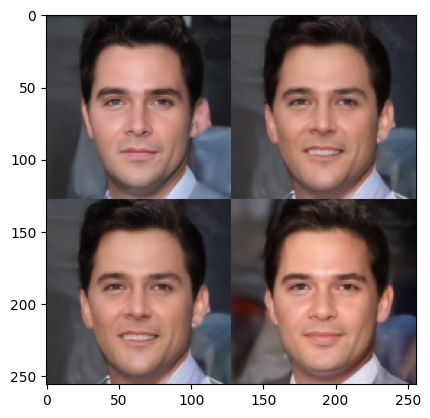

 - fs_imgs: shape=(1, 256, 256, 3)


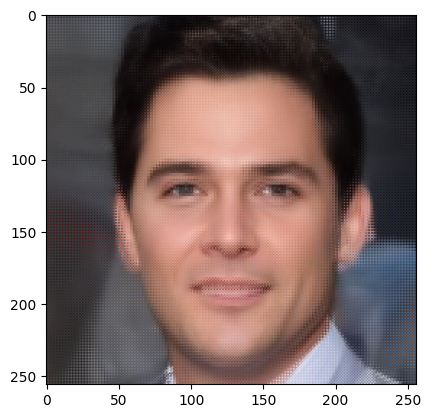

In [23]:
state = demo_C(model,stride = 50,eta = 0.4,n_last=15)
upz_samples = state.upz_samples 
h,w,c = upz_samples.shape[1:]
upz_grid = np.zeros((1,h*2,w*2,c))
for i in range(2):
    for j in range(2):
        upz_grid[0,h*i:h*i+h,w*j:w*j+w,:] = upz_samples[i+j,:,:,:]
up_imgs = z_samples_as_imgs(upz_grid)
print(f" - up_imgs: shape={up_imgs.shape}")
plt.imshow(up_imgs[0])
plt.show()

fs_imgs = z_samples_as_imgs(state.fsz_samples)
print(f" - fs_imgs: shape={fs_imgs.shape}")
plt.imshow(fs_imgs[0])
plt.show()


In [16]:
def demo_D(model,stride,eta,n_split,n_merge,c_merge):
    assert 0<=c_merge and c_merge<=1
    state = State()
    state.stride = stride
    state.eta = eta
    state = compute_schedule(state)
    state = generate_sampling_start(state)
    T_ = state.T_
    assert n_split+n_merge<T_
    for t in tqdm(range(T_-n_split-n_merge),ncols=0):
        t = T_ - t  - 1
        state = sampling_step(model,state,t,"z_samples")
    print(f" - At t/T={t}/{T_},state.z_samples: shape={state.z_samples.shape}")
    # upz_samples
    state.upz_samples = np.zeros((4, *(state.z_samples.shape[1:])))
    for i in range(4):
        state.upz_samples[i,...] = state.z_samples[0,...] # copy
        
    for t in tqdm(range(T_ - n_split-n_merge,T_-n_merge),ncols=0):
        t = T_ - t  - 1
        state = sampling_step(model,state,t,"upz_samples")
        
    print(f" - At t/T={t}/{T_},state.z_samples: shape={state.z_samples.shape}")
    print(f" - At t/T={t}/{T_},state.upz_samples: shape={state.upz_samples.shape}")
        
    
    # merge
    for t in tqdm(range(T_ - n_merge,T_),ncols=0):
        t = T_ - t  - 1
        for i in range(4):
            state.upz_samples[i,...] = c_merge* state.upz_samples[i,...] 
            for j in range(4):
                if i!=j:
                    state.upz_samples[i,...] += (1-c_merge)/3*state.upz_samples[j,...] 
        state = sampling_step(model,state,t,"upz_samples")
    print(f" - At t/T={t}/{T_},state.upz_samples: shape={state.upz_samples.shape}")
    
    h,w,c = state.upz_samples.shape[1:]
    state.fsz_samples = np.zeros((1, 2*h,2*w,c))
    
    for ix in range(h):
        for iy in range(w):
            for i in range(2):
                for j in range(2):
                    state.fsz_samples[0,2*ix+i,2*iy+j,:] = state.upz_samples[i+j,ix,iy,:]
        
        
    print(f" - After diffusion,state.fsz_samples: shape={state.fsz_samples.shape}")
    return state

  0% 0/5 [00:00<?, ?it/s]

100% 5/5 [00:00<00:00, 34.47it/s]


 - At t/T=35/40,state.z_samples: shape=(1, 128, 128, 3)


100% 30/30 [00:01<00:00, 15.49it/s]


 - At t/T=5/40,state.z_samples: shape=(1, 128, 128, 3)
 - At t/T=5/40,state.upz_samples: shape=(4, 128, 128, 3)


100% 5/5 [00:00<00:00, 14.89it/s]


 - At t/T=0/40,state.upz_samples: shape=(4, 128, 128, 3)
 - After diffusion,state.fsz_samples: shape=(1, 256, 256, 3)
 - up_imgs: shape=(1, 256, 256, 3)


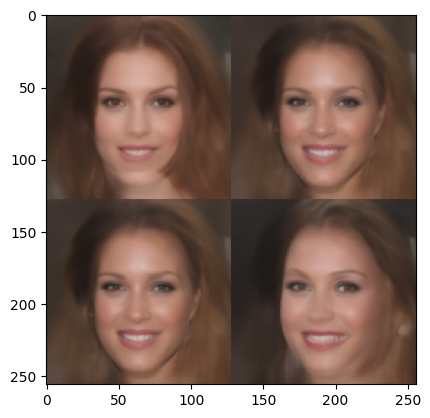

 - fs_imgs: shape=(1, 256, 256, 3)


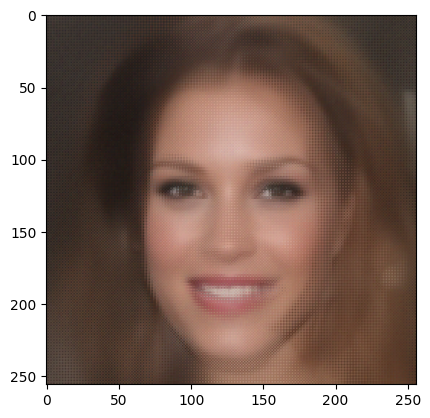

In [17]:
state = demo_D(model,stride = 25,eta = 1,n_split=30,n_merge=5,c_merge=0.8)
upz_samples = state.upz_samples 
h,w,c = upz_samples.shape[1:]
upz_grid = np.zeros((1,h*2,w*2,c))
for i in range(2):
    for j in range(2):
        upz_grid[0,h*i:h*i+h,w*j:w*j+w,:] = upz_samples[i+j,:,:,:]
up_imgs = z_samples_as_imgs(upz_grid)
print(f" - up_imgs: shape={up_imgs.shape}")
plt.imshow(up_imgs[0])
plt.show()

fs_imgs = z_samples_as_imgs(state.fsz_samples)
print(f" - fs_imgs: shape={fs_imgs.shape}")
plt.imshow(fs_imgs[0])
plt.show()


In comparison. a 256x256 image from dataset is


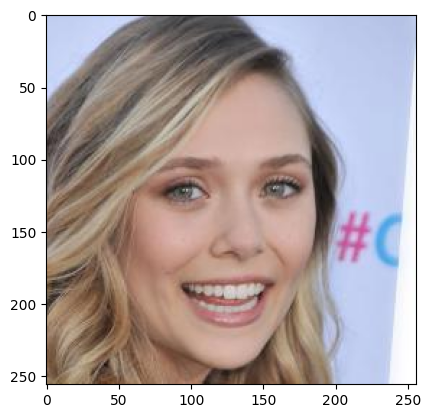

In [18]:
print("In comparison. a 256x256 image from dataset is")
show_image("/home/yumeng/workspace/DDPM-SuJL/sjldpm/apps/cond/29000-dataset.jpg")